# Sales Prediction With ARIMA

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt

In [2]:
# Read the data
df = pandas.read_csv('sales_data.csv')
df.head()

,sales,date
0,112,2022-08-21
1,118,2022-08-22
2,132,2022-08-23
3,129,2022-08-24
4,121,2022-08-25


In [3]:
# date to datetime object
df['date'] = pandas.to_datetime(df['date'])

# date to index
df.set_index('date', inplace=True)


In [4]:
# general info about the data
df.info()

# check if there are any missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2022-08-21 to 2023-01-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sales   144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


sales    0
dtype: int64

<AxesSubplot:xlabel='date'>

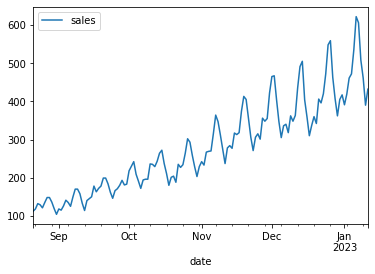

In [5]:
# plot the sales in a line chart
df.plot()

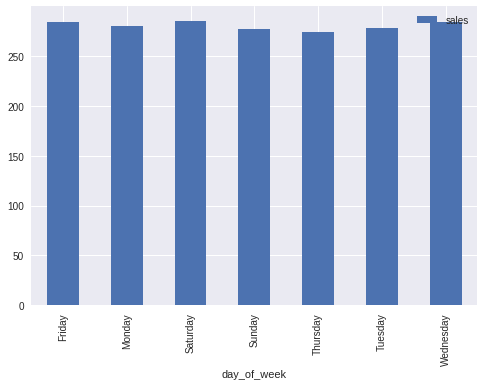

In [6]:
# lets find out if there's a pattern that some day of the week has the most sales
df_copy = df

df_copy['day_of_week'] = df_copy.index.day_name()

# avg of sales for each day of the week
week_avg = df_copy.groupby('day_of_week').mean()

# plot the week_avg
plt.style.use('seaborn')
week_avg.plot(kind='bar')
plt.show()

In [7]:
# split the data into train and test
from sklearn.model_selection import train_test_split

X = df.drop('sales', axis=1)
y = df['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

There are two things to consider before doing the ARIMA. It takes three parameters:  
p: the number of lag observations in the model, also known as the lag order.  
d: the number of times the raw observations are differenced; also known as the degree of differencing.  
q: the size of the moving average window, also known as the order of the moving average.  

The The Augmented Dickey-Fuller test will tell us if the data is stationary or not. It has a very clear trend so it should not be. If it is not, then we will have to have some differencing a.k.a. parameter d.

The autocorrelation plot will tell us how much of lagging we need. The autocorrelation tells us how much correlation does the time series have with a lagged version itself. So we're gonna try all p-values that still correlates.


In [8]:
# Setup and Import data
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
%matplotlib inline

# ADF Test
result = adfuller(df.sales, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: 0.8153688792060498
n_lags: 0.991880243437641
p-value: 0.991880243437641
Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


Okay we can see here that the ADF-test shows us that the data is not stationary like we expected. If the ADF-score is above all critical values and the p-value is over 0.05, that means our data is not stationary. So we need atleast value 1 in parameter d.

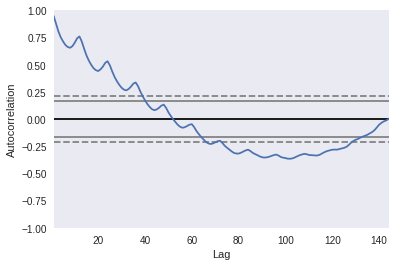

In [9]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df.sales)
pyplot.show()

In [10]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import numpy as np
import warnings

p_values = [15,20,25,30,40]
d_values = range(1, 3)
q_values = [0,1,2,3,5,10,20]

# home-made grid search
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            model = ARIMA(y_train, order=order).fit()
            warnings.filterwarnings('ignore')
            predictions = model.predict(start=len(y_train), end=len(y_train) + len(y_test)-1)
            error = mean_absolute_error(y_test, predictions)
            print('ARIMA%s MAE=%.3f' % (order,error))

/home/olli/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/olli/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/olli/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/olli/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/olli/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimi

ARIMA(15, 1, 0) MAE=37.928
ARIMA(15, 1, 1) MAE=38.651
ARIMA(15, 1, 2) MAE=37.404
ARIMA(15, 1, 3) MAE=36.967
ARIMA(15, 1, 5) MAE=37.075
ARIMA(15, 1, 10) MAE=27.701
ARIMA(15, 1, 20) MAE=26.857
ARIMA(15, 2, 0) MAE=97.190
ARIMA(15, 2, 1) MAE=25.952
ARIMA(15, 2, 2) MAE=27.181


KeyboardInterrupt: 

In [ ]:
# create the model
model = ARIMA(df.sales, order=(25,1,20))

# fit the model
model_fit = model.fit()

# predict the sales
forecast = model_fit.get_forecast(steps=len(y_test)*2)
y_pred = forecast.predicted_mean
y_pred_conf_int = forecast.conf_int(alpha=0.05)

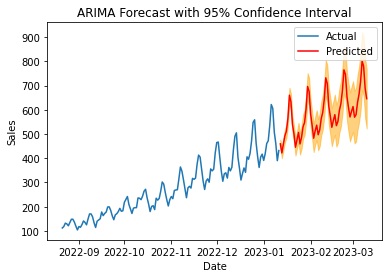

In [ ]:
import matplotlib.pyplot as plt

# plot the actual data
plt.plot(df.sales, label='Actual')

# plot the predicted mean values
plt.plot(y_pred, label='Predicted', color='red')

# plot the lower and upper bounds of the confidence interval as shaded regions
plt.fill_between(y_pred_conf_int.index, y_pred_conf_int.iloc[:, 0], y_pred_conf_int.iloc[:, 1], color='orange', alpha=0.5)

# add labels, title and legend
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('ARIMA Forecast with 95% Confidence Interval')
plt.legend(loc='upper left')

# put the fill_between color to legend
plt.legend(handles=[plt.Rectangle((0,0),1,1,fc='orange', alpha=0.5)], labels=['95% Confidence Interval'], loc='upper left')

# show the plot
plt.show()


In [ ]:
import pickle

# save the model to disk
filename = 'sales_model.sav'

# save the model to disk
pickle.dump(model_fit, open(filename, 'wb'))